In [30]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import Layout, Button, Box
from nested_dict import nested_dict
import ipywidgets as widgets

import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set(style="whitegrid")

In [31]:
artifacts_dir = "/etc/skel/sandmark-nightly/sequential/"

In [32]:
bench_files = []

artifacts_path = artifacts_dir.split("/sequential/")[0]
print(artifacts_path)

for root, dirs, files in os.walk(artifacts_dir):
#     print(dirs)
    for file in files:
#         print(file)
        if file.endswith("_1.orun.summary.bench"):
            # print(root)
            f = root.split("/sequential/")
#             print(f)
            bench_files.append((os.path.join(root, file)))

print(bench_files)

/etc/skel/sandmark-nightly
['/etc/skel/sandmark-nightly/sequential/20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench', '/etc/skel/sandmark-nightly/sequential/20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench', '/etc/skel/sandmark-nightly/sequential/20210531_060002/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench', '/etc/skel/sandmark-nightly/sequential/20210601_000015/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench', '/etc/skel/sandmark-nightly/sequential/20210601_000015/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench', '/etc/skel/sandmark-nightly/sequential/20210604_000002/6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b/4.12.0+domains+effects_1.orun.summary.bench', '/etc/skel/sandmark-nightly/sequential/20210604_000002/6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b/4.12.0+stock_1.orun.summary.bench', '/etc/skel/sandmar

In [33]:
# len(bench_files)
for b in bench_files :
    print(b + '\n')

/etc/skel/sandmark-nightly/sequential/20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench

/etc/skel/sandmark-nightly/sequential/20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench

/etc/skel/sandmark-nightly/sequential/20210531_060002/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench

/etc/skel/sandmark-nightly/sequential/20210601_000015/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench

/etc/skel/sandmark-nightly/sequential/20210601_000015/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench

/etc/skel/sandmark-nightly/sequential/20210604_000002/6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b/4.12.0+domains+effects_1.orun.summary.bench

/etc/skel/sandmark-nightly/sequential/20210604_000002/6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b/4.12.0+stock_1.orun.summary.bench

/etc/skel/sandmark-nightly/sequential/20210528_174921/80580f

In [34]:
benches = nested_dict(2, list)
for x in bench_files:
#     print(x)
    l = x.split("/sequential/")[1]
    print(l)
    d = l.split("/")
#     print(d)
    timestamp  = d[0]
    commit     = d[1]
    variant    = d[2]
    value      = timestamp + " " + commit + " " + variant
    benches[timestamp][commit].append(value)
benches = benches.to_dict()

20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench
20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench
20210531_060002/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench
20210601_000015/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench
20210601_000015/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench
20210604_000002/6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b/4.12.0+domains+effects_1.orun.summary.bench
20210604_000002/6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b/4.12.0+stock_1.orun.summary.bench
20210528_174921/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench
20210528_174921/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+stock_1.orun.summary.bench
20210602_000014/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench
20210602_000014/80580f1d913a70fd3cb4847f

In [35]:
benches

{'20210527_084314': {'80580f1d913a70fd3cb4847f828ce6a7d284a05c': ['20210527_084314 80580f1d913a70fd3cb4847f828ce6a7d284a05c 4.12.0+domains+effects_1.orun.summary.bench',
   '20210527_084314 80580f1d913a70fd3cb4847f828ce6a7d284a05c 4.12.0+stock_1.orun.summary.bench']},
 '20210531_060002': {'80580f1d913a70fd3cb4847f828ce6a7d284a05c': ['20210531_060002 80580f1d913a70fd3cb4847f828ce6a7d284a05c 4.12.0+stock_1.orun.summary.bench']},
 '20210601_000015': {'80580f1d913a70fd3cb4847f828ce6a7d284a05c': ['20210601_000015 80580f1d913a70fd3cb4847f828ce6a7d284a05c 4.12.0+domains+effects_1.orun.summary.bench',
   '20210601_000015 80580f1d913a70fd3cb4847f828ce6a7d284a05c 4.12.0+stock_1.orun.summary.bench']},
 '20210604_000002': {'6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b': ['20210604_000002 6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b 4.12.0+domains+effects_1.orun.summary.bench',
   '20210604_000002 6ea276a3d6c81dab9e10aafdb22fa85ab2b0e17b 4.12.0+stock_1.orun.summary.bench']},
 '20210528_174921': {'80580f1d9

In [36]:
def f(x): return x

def disp(benches):    
    def select_commit(timestamp):
        commitW.options = benches[timestamp]

    def select_variant(commit):
        variantW.options = commit
    
    def stub(variant):
        return None
    
    timestampW = widgets.Dropdown(options=benches.keys(), description='Timestamp', disabled=False)
    timestampS = timestampW.value
    timestampD = widgets.interactive(select_commit, timestamp=timestampW)
    
    commitW = widgets.Dropdown(options=benches[timestampS].keys(), description='Commit', disabled=False)
    commitS = commitW.value
    commitD = widgets.interactive(select_variant, commit=commitW)
    
#     variant_options = [x.split(' ')[2] for x in benches[timestampS][commitS]]
    variantW = widgets.Dropdown(options=benches[timestampS][commitS], description='Variant', disabled=False)
    variantS = variantW.value
    variantD = widgets.interactive(stub, variant=variantW)

    items_layout = Layout( width='auto' )
    
    box_layout = Layout(display='flex',
                       flex_flow='row wrap',
                       align_items='flex-start',
                       #border='solid',
                       width='100%')
    
    items = [timestampD, commitD, variantD]
    box = Box(children=items, layout=box_layout)
#     print(box)
    display(box)
    return (timestampD, commitD, variantD)

def get_filename(timestamp, variant):
    timestamp = timestamp.children[0].value
    commit_id = variant.children[0].value.split(' ')[1]
    variant   = variant.children[0].value.split(' ')[2] 
    filename = os.path.join(
        artifacts_path, 
        "sequential", 
        timestamp,
        commit_id,
        variant
        )
    print(filename)
    return filename

In [37]:
comparisons = interactive(f, x=widgets.IntText(value=2, 
                                               description='Comparisons', 
                                               disabled=False))
display(comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [38]:
print(comparisons.result)

2


In [39]:
matrix = [[0 for x in range(4)] for y in range(comparisons.result)]  
    
for i in range(comparisons.result):
    matrix[i][0], matrix[i][1], matrix[i][2] = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210527_084314', '20210531_06…

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210527_084314', '20210531_06…

In [46]:
for i in range(comparisons.result):
    matrix[i][3] = get_filename(matrix[i][0], matrix[i][2])

# print(matrix[0][2])
# print(matrix[1][2])

/etc/skel/sandmark-nightly/sequential/20210528_174921/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench
/etc/skel/sandmark-nightly/sequential/20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench


In [47]:
selected_files = []
for i in range (comparisons.result):
    print(matrix[i][3])
    selected_files.append(matrix[i][3])

# print(selected_files)

/etc/skel/sandmark-nightly/sequential/20210528_174921/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench
/etc/skel/sandmark-nightly/sequential/20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench


In [48]:
data_frames = []

for file in selected_files:
    print(file)
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        value = file.split('/sequential/')[1]
        value = value.split('/')
        value = value[0].split('_')[0] + '_' + value[1][:7] + '_' + value[2].replace("_1.orun.summary.bench","")
#         print(value)
        df["variant"] = value
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name']) 
# Uncomment the following to display all the lines in pandas output
pd.set_option('display.max_rows', df.shape[0]+1)
df

/etc/skel/sandmark-nightly/sequential/20210528_174921/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench
/etc/skel/sandmark-nightly/sequential/20210527_084314/80580f1d913a70fd3cb4847f828ce6a7d284a05c/4.12.0+domains+effects_1.orun.summary.bench


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if __name__ == '__main__':


,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
11,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.187735,4.171401,0.015997,37924,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2153773382,166,4194792,8217,2,0,4231434,4231434,3.492858,20210527_80580f1_4.12.0+domains+effects
11,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.190830,4.174525,0.015994,37956,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2153773382,166,4194792,8217,2,0,4231434,4231434,3.492858,20210528_80580f1_4.12.0+domains+effects
24,alt-ergo.fill.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,2.449274,2.176867,0.272108,425640,2865246.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,168246842,43600151,60772223,653,17,0,51724355,52392003,5.562723,20210527_80580f1_4.12.0+domains+effects
24,alt-ergo.fill.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,2.434599,2.235117,0.199208,425824,2865246.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,168246842,43600151,60772223,653,17,0,51724355,52392003,5.562723,20210528_80580f1_4.12.0+domains+effects
13,alt-ergo.yyll.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,18.130999,17.979889,0.150660,318592,2865246.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2044232435,54649002,83490698,7824,27,0,38252217,38252217,25.387974,20210527_80580f1_4.12.0+domains+effects
13,alt-ergo.yyll.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,18.077731,17.914499,0.162745,318756,2865246.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2044232443,54648961,83490667,7824,27,0,38256313,38256313,25.387765,20210528_80580f1_4.12.0+domains+effects
36,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.418580,5.402240,0.016006,22332,164078.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,1227959520,1951995,2484415,4695,10,0,2023316,2088855,24.370582,20210528_80580f1_4.12.0+domains+effects
36,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.377109,5.364821,0.012001,22400,164078.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,1227959520,1951995,2484415,4695,10,0,2023316,2088855,24.370582,20210527_80580f1_4.12.0+domains+effects
43,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,11.782520,11.730204,0.052009,146876,282776.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,916489945,280594226,280594544,3565,69,0,15786238,18084094,38.706226,20210527_80580f1_4.12.0+domains+effects
43,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,11.833335,11.744989,0.088007,146828,282776.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,916489945,280594226,280594544,3565,69,0,15786238,18084094,38.706226,20210528_80580f1_4.12.0+domains+effects


In [49]:
df = df[(df.name != 'alt-ergo.fill.why') &         #multicore version does not exist
        (df.name != 'alt-ergo.yyll.why') &         #multicore version does not exist
        (df.name != 'frama-c.slevel') &            #multicore version does not exist
        (df.name != 'js_of_ocaml.frama-c_byte')]   #multicore version does not exist
throughput_df = df
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
11,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.187735,4.171401,0.015997,37924,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2153773382,166,4194792,8217,2,0,4231434,4231434,3.492858,20210527_80580f1_4.12.0+domains+effects
11,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.190830,4.174525,0.015994,37956,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2153773382,166,4194792,8217,2,0,4231434,4231434,3.492858,20210528_80580f1_4.12.0+domains+effects
36,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.418580,5.402240,0.016006,22332,164078.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,1227959520,1951995,2484415,4695,10,0,2023316,2088855,24.370582,20210528_80580f1_4.12.0+domains+effects
36,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.377109,5.364821,0.012001,22400,164078.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,1227959520,1951995,2484415,4695,10,0,2023316,2088855,24.370582,20210527_80580f1_4.12.0+domains+effects
43,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,11.782520,11.730204,0.052009,146876,282776.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,916489945,280594226,280594544,3565,69,0,15786238,18084094,38.706226,20210527_80580f1_4.12.0+domains+effects
43,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,11.833335,11.744989,0.088007,146828,282776.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,916489945,280594226,280594544,3565,69,0,15786238,18084094,38.706226,20210528_80580f1_4.12.0+domains+effects
35,chameneos_redux_lwt.600000,taskset --cpu-list 5 ./chameneos_redux_lwt.exe...,4.437317,2.354428,2.082610,6892,417561.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,548093885,747983,748301,2144,57,0,102654,102654,389.769162,20210527_80580f1_4.12.0+domains+effects
35,chameneos_redux_lwt.600000,taskset --cpu-list 5 ./chameneos_redux_lwt.exe...,4.440102,2.279890,2.159895,6872,417561.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,548093885,747983,748301,2144,57,0,102654,102654,389.769162,20210528_80580f1_4.12.0+domains+effects
49,coq.AbstractInterpretation.v,taskset --cpu-list 5 coqc benchmarks/coq/Abstr...,325.890934,324.633393,1.255989,1180672,5910872.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,71170430518,660252225,974735111,271639,79,0,71309762,118394012,44.526326,20210528_80580f1_4.12.0+domains+effects
49,coq.AbstractInterpretation.v,taskset --cpu-list 5 coqc benchmarks/coq/Abstr...,324.774801,323.293295,1.479987,1182180,5910872.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,71170430563,660234817,974717705,271639,79,0,71174594,118574236,44.534951,20210527_80580f1_4.12.0+domains+effects


In [15]:
baseline_t, baseline_c, baseline_v = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210527_084314', '20210531_06…

In [50]:
selected_baseline = ""
value = baseline_v.children[0].value.split(' ')
value = value[0].split('_')[0] + '_' + value[1][:7] + '_' + value[2].replace('_1.orun.summary.bench', '')
selected_baseline = value

print(selected_baseline)

20210527_80580f1_4.12.0+domains+effects


In [51]:
df.loc[(df['variant'] == selected_baseline) & (df['time_secs'] > 10)]

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
43,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,11.782520,11.730204,0.052009,146876,282776.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,916489945,280594226,280594544,3565,69,0,15786238,18084094,38.706226,20210527_80580f1_4.12.0+domains+effects
49,coq.AbstractInterpretation.v,taskset --cpu-list 5 coqc benchmarks/coq/Abstr...,324.774801,323.293295,1.479987,1182180,5910872.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,71170430563,660234817,974717705,271639,79,0,71174594,118574236,44.534951,20210527_80580f1_4.12.0+domains+effects
7,coq.BasicSyntax.v,taskset --cpu-list 5 coqc benchmarks/coq/Basic...,112.327311,111.958123,0.368006,668236,5910872.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,23594803450,328361000,341582960,90113,42,0,53856676,56310940,37.545301,20210527_80580f1_4.12.0+domains+effects
39,cpdf.scale,taskset --cpu-list 5 cpdf scale-to-fit a4lands...,14.083414,13.831030,0.251982,288224,1139519.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,592505902,85185522,95775244,2286,28,0,33343919,34731704,27.234306,20210527_80580f1_4.12.0+domains+effects
45,cpdf.squeeze,taskset --cpu-list 5 cpdf -squeeze benchmarks/...,16.281023,16.020579,0.260009,372220,1139519.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,422126124,124455393,140126340,1655,32,0,29010811,45884648,28.547347,20210527_80580f1_4.12.0+domains+effects
44,cubicle.german_pfs.cub,taskset --cpu-list 5 cubicle benchmarks/cubicl...,256.324385,255.713425,0.607990,415924,1231574.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,20163432254,439124457,3516671718,77212,454,0,33317674,57952548,114.296262,20210527_80580f1_4.12.0+domains+effects
27,cubicle.szymanski_at.cub,taskset --cpu-list 5 cubicle benchmarks/cubicl...,506.731355,506.511514,0.215997,174580,1231574.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,106101413426,6203936942,6425840573,406196,1471,0,16786314,27081770,86.568743,20210527_80580f1_4.12.0+domains+effects
16,evolutionary_algorithm.10000_10000,taskset --cpu-list 5 ./evolutionary_algorithm....,70.660731,68.676092,1.984002,3336128,169604.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,3728901136,715343,1300975674,14254,30,0,398692754,426287883,14.025228,20210527_80580f1_4.12.0+domains+effects
32,fannkuchredux.12,taskset --cpu-list 5 ./fannkuchredux.exe 12,98.256939,98.256570,0.000000,5172,282878.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,5856,0,318,0,0,0,4350,4350,0.000000,20210527_80580f1_4.12.0+domains+effects
31,fannkuchredux2.12,taskset --cpu-list 5 ./fannkuchredux2.exe 12,94.269844,94.269483,0.000000,5280,283142.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,5864,0,318,0,0,0,4350,4350,0.000000,20210527_80580f1_4.12.0+domains+effects


In [52]:
df.filter(['name','variant','time_secs'])
# print(len(df))

,name,variant,time_secs
11,LU_decomposition.1024,20210527_80580f1_4.12.0+domains+effects,4.187735
11,LU_decomposition.1024,20210528_80580f1_4.12.0+domains+effects,4.190830
36,bdd.26,20210528_80580f1_4.12.0+domains+effects,5.418580
36,bdd.26,20210527_80580f1_4.12.0+domains+effects,5.377109
43,binarytrees5.21,20210527_80580f1_4.12.0+domains+effects,11.782520
43,binarytrees5.21,20210528_80580f1_4.12.0+domains+effects,11.833335
35,chameneos_redux_lwt.600000,20210527_80580f1_4.12.0+domains+effects,4.437317
35,chameneos_redux_lwt.600000,20210528_80580f1_4.12.0+domains+effects,4.440102
49,coq.AbstractInterpretation.v,20210528_80580f1_4.12.0+domains+effects,325.890934
49,coq.AbstractInterpretation.v,20210527_80580f1_4.12.0+domains+effects,324.774801


## Time

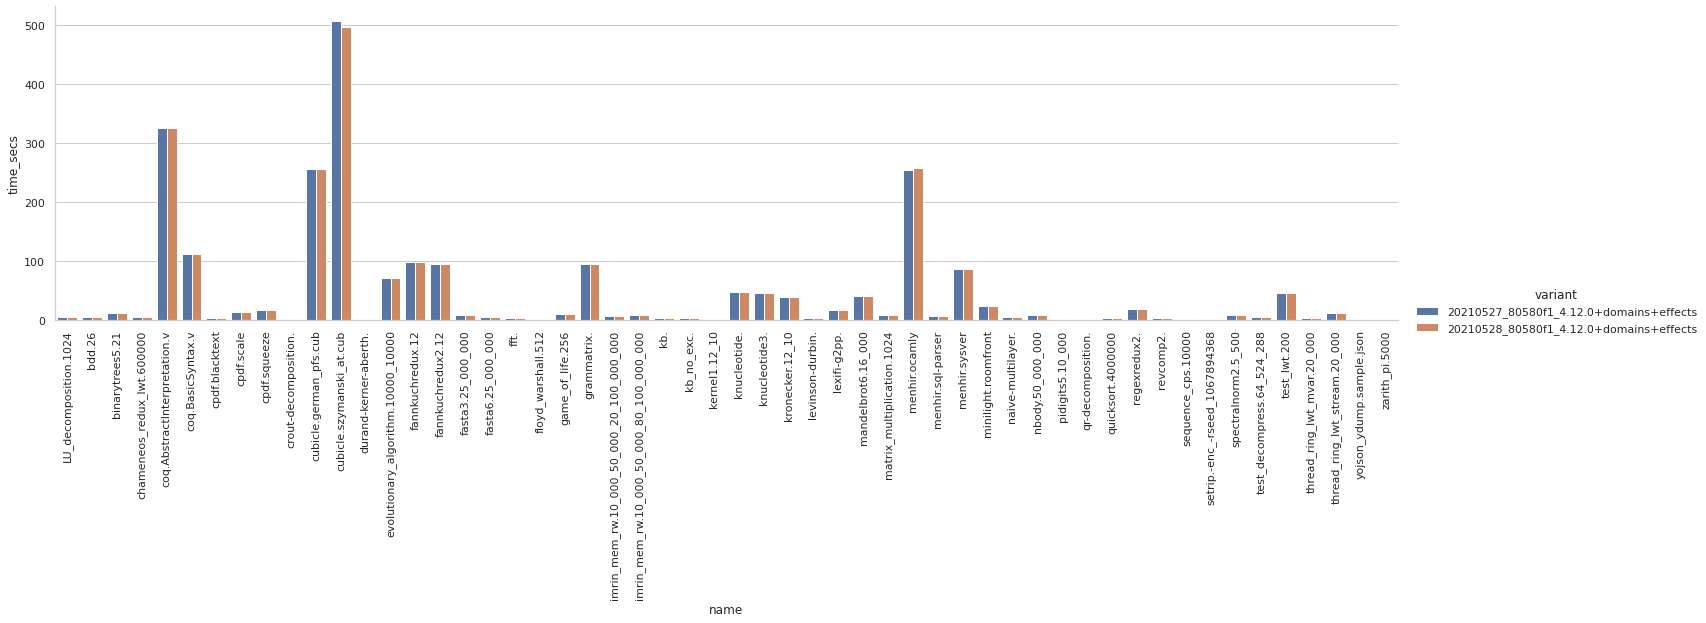

In [53]:
g = sns.catplot (x='name', y='time_secs', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalized

In [54]:
# returns a dictionary with {key = name : value : metric}
# the metric corresponds to the variant
def create_column(df, variant, metric):
    df = pd.DataFrame.copy(df)
#     print(df['variant'])
    variant_metric_name = list([ zip(df[metric], df[x], df['name'])
            for x in df.columns.array if x == "variant" ][0])
    name_metric = {n:t for (t, v, n) in variant_metric_name if v == variant}
#     print(name_metric)
    return name_metric

def add_display_name(df,variant, metric):
    name_metric = create_column(pd.DataFrame.copy(df), variant, metric)
#     print(name_metric)
    disp_name = [name+" ("+str(round(name_metric[name], 2))+")" for name in df["name"]]
    df["display_name"] = pd.Series(disp_name, index=df.index)
#     print(df)
    return df

def normalise(df,variant,topic,additionalTopics=[]):
    df = add_display_name(df,variant,topic)
    df = df.sort_values(["name","variant"])
#     print(df)
    grouped = df.filter(items=['name',topic,'variant','display_name']+additionalTopics).groupby('variant')
    ndata_frames = []
    for group in grouped:
#         print(group)
        (v,data) = group
#         print(len(data[topic]))
        if(v != variant):
            data['b'+topic] = grouped.get_group(variant)[topic].values
            data[['n'+topic]] = data[[topic]].div(grouped.get_group(variant)[topic].values, axis=0)
            for t in additionalTopics:
#                 print(variant, t)
                data[[t]] = grouped.get_group(variant)[t].values
            ndata_frames.append(data)
    df = pd.concat (ndata_frames)
    return df

def plot_normalised(df,variant,topic):
    df = pd.DataFrame.copy(df)
    df.sort_values(by=[topic],inplace=True)
    df[topic] = df[topic] - 1
    g = sns.catplot (x="display_name", y=topic, hue='variant', data = df, kind ='bar', aspect=4, bottom=1)
    g.set_xticklabels(rotation=90)
    g.ax.legend(loc=8)
    g._legend.remove()
    g.ax.set_xlabel("Benchmarks")
    return g
    # g.ax.set_yscale('log')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


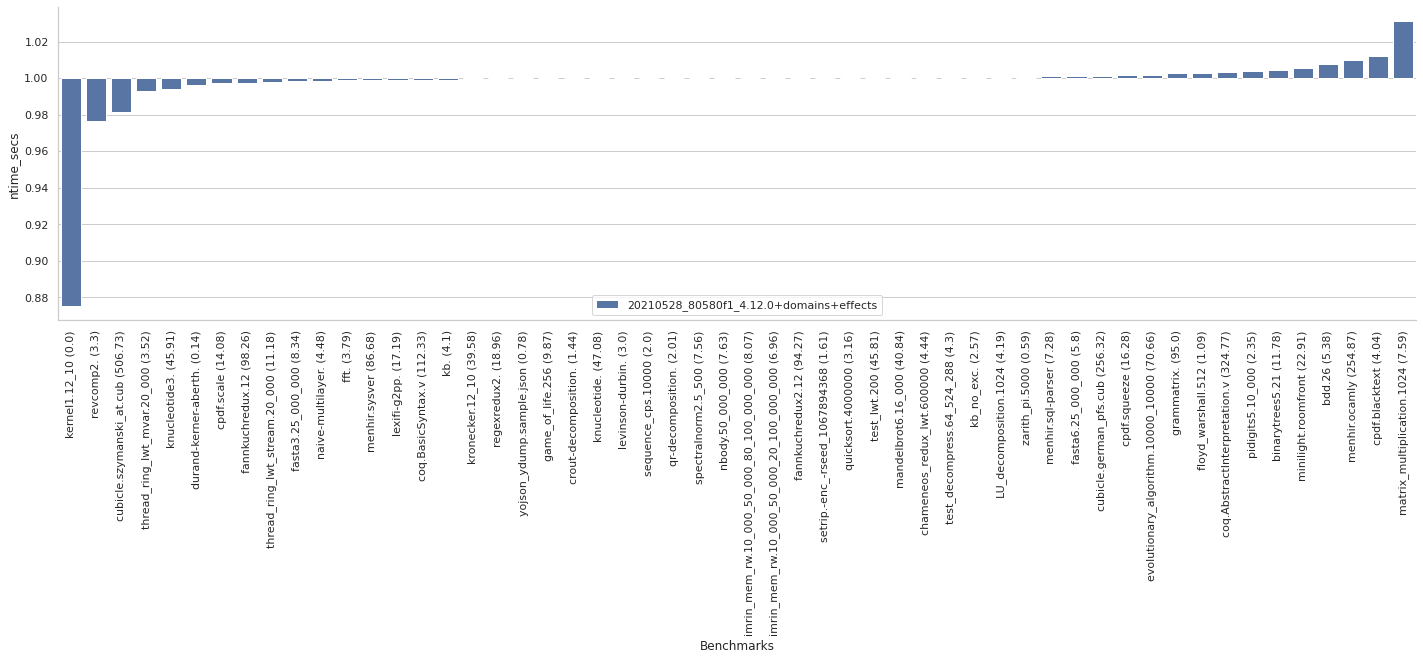

In [55]:
# print(df)
ndf = normalise(df, selected_baseline,'time_secs')
plot_normalised(ndf, selected_baseline,'ntime_secs')